# HANK model with housing and collateral constraints

In [13]:
# importing packages to be used in the notebook
import numpy as np
import matplotlib.pyplot as plt
import numba

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 10})

from sequence_jacobian import simple, solved, combine, create_model  # functions
from sequence_jacobian import grids, hetblocks                       # modules
from sequence_jacobian import interpolate
from scipy.interpolate import interp1d

import hh_housing

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Comparision with HANK model from SSJ toolkit

In [17]:
@solved(unknowns={'pi': (-0.1, 0.1)}, targets=['nkpc'], solver="brentq")
def pricing_solved(pi, mc, r, Y, kappap, mup):
    nkpc = kappap * (mc - 1/mup) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / \
           (1 + r(+1)) - (1 + pi).apply(np.log)
    return nkpc

@solved(unknowns={'p': (5, 15)}, targets=['equity'], solver="brentq")
def arbitrage_solved(div, p, r):
    equity = div(+1) + p(+1) - p * (1 + r(+1))
    return equity

@simple
def labor(Y, w, K, Z, alpha):
    N = (Y / Z / K(-1) ** alpha) ** (1 / (1 - alpha))
    mc = w * N / (1 - alpha) / Y
    return N, mc


@simple
def investment(Q, K, r, N, mc, Z, delta, epsI, alpha):
    inv = (K / K(-1) - 1) / (delta * epsI) + 1 - Q
    val = alpha * Z(+1) * (N(+1) / K) ** (1 - alpha) * mc(+1) -\
        (K(+1) / K - (1 - delta) + (K(+1) / K - 1) ** 2 / (2 * delta * epsI)) +\
        K(+1) / K * Q(+1) - (1 + r(+1)) * Q
    return inv, val


production = combine([labor, investment])                              # create combined block
production_solved = production.solved(unknowns={'Q': 1., 'K': 10.},    # turn it into solved block
                                      targets=['inv', 'val'],
                                      solver='broyden_custom')

In [18]:
def make_grids(bmax, amax, kmax, nB, nA, nK, nZ, rho_z, sigma_z):
    b_grid = grids.agrid(amax=bmax, n=nB)
    a_grid = grids.agrid(amax=amax, n=nA)
    k_grid = grids.agrid(amax=kmax, n=nK)[::-1].copy()
    e_grid, _, Pi = grids.markov_rouwenhorst(rho=rho_z, sigma=sigma_z, N=nZ)
    return b_grid, a_grid, k_grid, e_grid, Pi


def income(e_grid, tax, w, N):
    z_grid = (1 - tax) * w * N * e_grid
    return z_grid

hh = hetblocks.hh_twoasset.hh
hh_ext = hh.add_hetinputs([income, make_grids])
# print(hh_ext.outputs)

import sequence_jacobian.examples.two_asset as m

blocks = [hh_ext, production_solved, pricing_solved, arbitrage_solved,
          m.dividend, m.taylor, m.fiscal, m.share_value,
          m.finance, m.wage, m.union, m.mkt_clearing]

hank = create_model(blocks, name='Two-Asset HANK')

# print(*hank.blocks, sep='\n')

blocks_ss = [hh_ext, m.partial_ss, m.union_ss,
             m.dividend, m.taylor, m.fiscal, m.share_value, m.finance, m.mkt_clearing]

hank_ss = create_model(blocks_ss, name='Two-Asset HANK SS')

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")

calibration = {'Y': 1., 'N': 1.0, 'K': 10., 'r': 0.0125, 'rstar': 0.0125, 'tot_wealth': 14,
               'delta': 0.02, 'pi': 0., 'kappap': 0.1, 'muw': 1.1, 'Bh': 1.04, 'Bg': 2.8,
               'G': 0.2, 'eis': 0.5, 'frisch': 1., 'chi0': 0.25, 'chi2': 2, 'epsI': 4,
               'omega': 0.005, 'kappaw': 0.1, 'phi': 1.5, 'nZ': 3, 'nB': 50, 'nA': 70, 'nK': 50,
               'bmax': 50, 'amax': 4000, 'kmax': 1, 'rho_z': 0.966, 'sigma_z': 0.92}

unknowns_ss = {'beta': 0.976, 'chi1': 6.5}
targets_ss = {'asset_mkt': 0., 'B': 'Bh'}

cali = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver='broyden_custom')

ss =  hank.steady_state(cali)

print(f"Liquid assets: {ss['B']: 0.2f}")
print(f"Asset market clearing: {ss['asset_mkt']: 0.2e}")
print(f"Goods market clearing (untargeted): {ss['goods_mkt']: 0.2e}")

<Model 'Two-Asset HANK SS'>
Inputs: ['beta', 'eis', 'chi0', 'chi1', 'chi2', 'N', 'bmax', 'amax', 'kmax', 'nB', 'nA', 'nK', 'nZ', 'rho_z', 'sigma_z', 'Y', 'K', 'r', 'tot_wealth', 'Bg', 'delta', 'muw', 'frisch', 'pi', 'kappap', 'epsI', 'rstar', 'phi', 'G', 'Bh', 'omega']
Liquid assets:  1.04
Asset market clearing:  7.35e-13
Goods market clearing (untargeted):  3.29e-08


## Simple partial equilibrium model to replicate two-asset HANK

Creating a simple partial equilibrium model to get the steady state policy functions

Block 1: household block

In [19]:
def make_grids(bmax, amax, kmax, nB, nA, nK, nZ, rho_z, sigma_z):
    b_grid = grids.agrid(amax=bmax, n=nB, amin = 0.0)
    a_grid = grids.agrid(amax=amax, n=nA)
    k_grid = grids.agrid(amax=kmax, n=nK)[::-1].copy()
    e_grid, _, Pi = grids.markov_rouwenhorst(rho=rho_z, sigma=sigma_z, N=nZ)
    return b_grid, a_grid, k_grid, e_grid, Pi


def income(e_grid, tax, w, N):
    z_grid = (1 - tax) * w * N * e_grid
    return z_grid

hh = hh_housing.hh
hh_ext = hh.add_hetinputs([income, make_grids])
print(hh_ext.outputs)

['A', 'B', 'C', 'UCE', 'CHI']


In [20]:
@simple
def mkt_clearing(C, Y):
    goods_mkt = C - Y
    return goods_mkt

blocks_ss = [hh_ext, mkt_clearing]
hank_ss = create_model(blocks_ss, name='Partial Equilibrium')
print(hank_ss.inputs)
calibration = {'nZ': 3, 'nB': 50, 'nA': 70, 'nK': 50,'bmax': 50, 'amax': 4000, 
               'kmax': 1, 'rho_z': 0.966, 'sigma_z': 0.92, 'tax': 0.3560606060606061,
               'w': 0.66, 'N': 1.0, 'beta': 0.9762739008880041, 'eis': 0.5,
               'rb': 0.007500000000000001, 'ra': 0.012499999999999956, 'chi0': 0.25,
               'chi1': 6.416419594214063, 'chi2': 2}

unknowns_ss = {'Y': 1.0}
targets_ss = {'goods_mkt': 0.0}

cali = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver='hybr')

['beta', 'eis', 'rb', 'ra', 'chi0', 'chi1', 'chi2', 'tax', 'w', 'N', 'bmax', 'amax', 'kmax', 'nB', 'nA', 'nK', 'nZ', 'rho_z', 'sigma_z', 'Y']


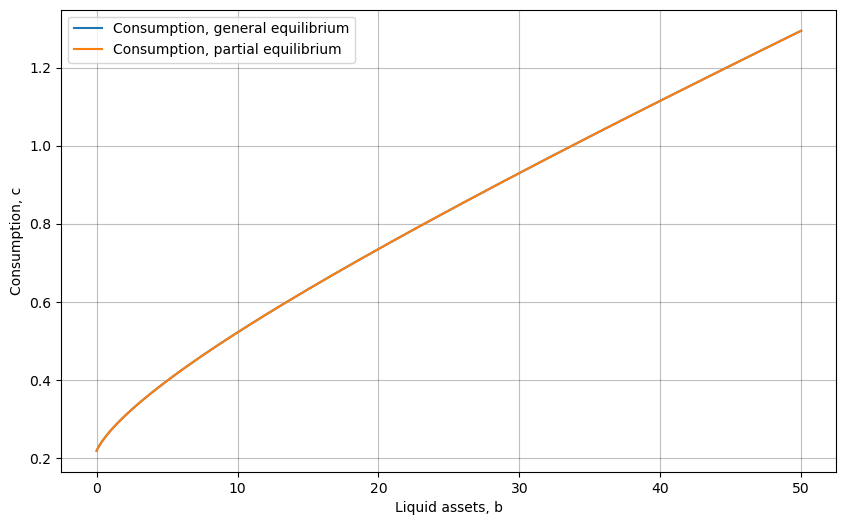

In [21]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1,1,1)

ax.plot(ss.internals['hh']['b_grid'], ss.internals['hh']['c'][1,:,1].T, label = 'Consumption, general equilibrium')
ax.plot(cali.internals['hh']['b_grid'], cali.internals['hh']['c'][1,:,1].T, label = 'Consumption, partial equilibrium')
ax.set_xlabel('Liquid assets, b')
ax.set_ylabel('Consumption, c')
ax.legend()

plt.show()

In [87]:
ss.internals['hh']['c'].shape

(3, 50, 70)

# Older stuff currently not in use

## Plotting the state space

Plotting the state-space

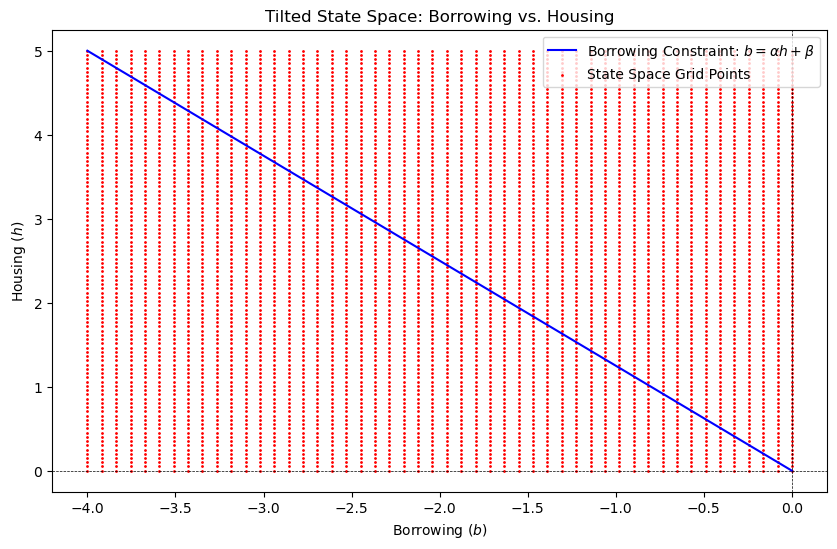

In [121]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 0.8  # slope of the borrowing constraint
beta = 5   # intercept of the borrowing constraint
h_min = 0  # minimum housing value
h_max = 5  # maximum housing value
nB = 50  # number of grid points in the borrowing dimension
nH = 100  # number of grid points in the housing dimension

# Borrowing constraint function
h_values = np.linspace(h_min, h_max, nH)  # range of housing values
b_values = -gamma * h_values # borrowing as a function of housing

h_grid, b_grid = np.meshgrid(h_values, np.linspace(min(b_values), max(b_values), nB))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(b_values, h_values, label='Borrowing Constraint: $b = \\alpha h + \\beta$', color='blue')
plt.scatter(b_grid, h_grid, s=1, color='red', label='State Space Grid Points')
plt.title('Tilted State Space: Borrowing vs. Housing')
plt.xlabel('Borrowing ($b$)')
plt.ylabel('Housing ($h$)')
plt.axhline(0, color='black', linewidth=0.5, ls='--')
plt.axvline(0, color='black', linewidth=0.5, ls='--')
plt.grid()
plt.legend()
# plt.xlim(h_min, h_max)
# plt.ylim(min(b_values) - 5, max(b_values) + 5)
plt.show()


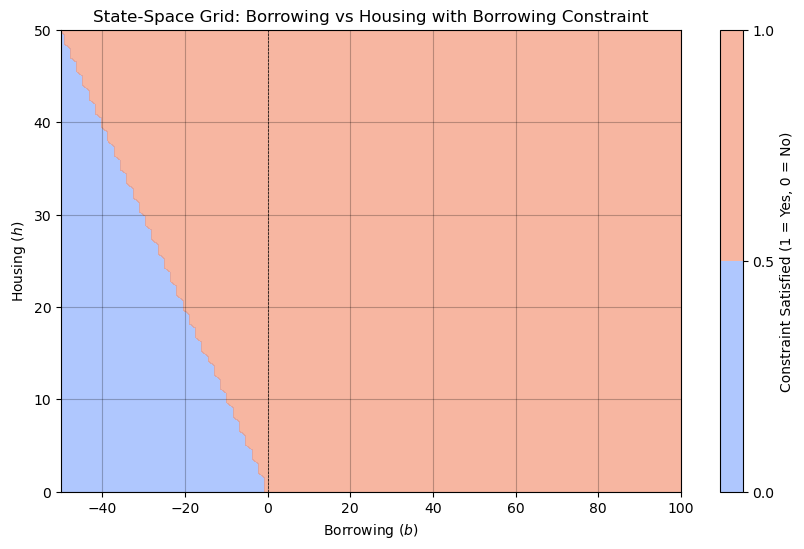

In [122]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for borrowing constraint
gamma = 0.5  # Sensitivity of borrowing constraint to housing
q = 2  # Price of housing

# Grid ranges for borrowing (b) and housing (h)
b_min, b_max = -50, 100  # Borrowing range
h_min, h_max = 0, 50     # Housing range
n_points = 100  # Number of points in the grid

# Create the grid of b and h
b_values = np.linspace(b_min, b_max, n_points)
h_values = np.linspace(h_min, h_max, n_points)
B, H = np.meshgrid(b_values, h_values)

# Borrowing constraint: b >= -gamma * q * h
borrowing_constraint = -gamma * q * H

# Visualize the state space and constraint
plt.figure(figsize=(10, 6))
plt.contourf(B, H, B >= borrowing_constraint, cmap='coolwarm', alpha=0.7)  # State space grid with constraint
plt.title('State-Space Grid: Borrowing vs Housing with Borrowing Constraint')
plt.xlabel('Borrowing ($b$)')
plt.ylabel('Housing ($h$)')
plt.colorbar(label='Constraint Satisfied (1 = Yes, 0 = No)')
plt.axhline(0, color='black', linewidth=0.5, ls='--')
plt.axvline(0, color='black', linewidth=0.5, ls='--')
plt.grid(True)
plt.show()


## Block 1: Households

In [88]:
def make_grids(bmax, amax, kmax, nB, nA, nK, nZ, rho_z, sigma_z):
    b_grid = grids.agrid(amax=bmax, n=nB)
    a_grid = grids.agrid(amax=amax, n=nA)
    k_grid = grids.agrid(amax=kmax, n=nK)[::-1].copy()
    e_grid, _, Pi = grids.markov_rouwenhorst(rho=rho_z, sigma=sigma_z, N=nZ)
    return b_grid, a_grid, k_grid, e_grid, Pi

def income(e_grid, tax, w, N):
    z_grid = (1 - tax) * w * N * e_grid
    return z_grid

hh_pe = hh_housing.hh_sandbox
# hh_ext = hh.add_hetinputs([income, make_grids])

In [5]:
def policy_ss(a_grid, b_grid, z_grid, e_grid, k_grid, beta, eis, rb, ra, chi0, chi1, chi2, gamma, tol=1E-12, max_iter=10_000, debug = False):
    # initialize value function and policy function
    Va_p, Vb_p = hh_housing.hh_init(b_grid, a_grid, z_grid, eis)
    
    Psi1 = hh_housing.marginal_cost_grid(a_grid, ra, chi0, chi1, chi2)
    # iterate until maximum distance between two iterations falls below tol, fail-safe max of 10,000 iterations
    for it in range(max_iter):
        Va_p, Vb_p, a, b, c, _ = hh_pe(Va_p, Vb_p, a_grid, b_grid, z_grid, e_grid, k_grid, beta, eis, rb, ra, chi0, chi1, chi2, gamma, Psi1, debug)
        
        # if it % 1000 == 0 and it > 0:
        #     print("Iteration:", it)
        #     print("Max difference in a:", np.max(np.abs(a - a_old)))
        #     print("Max difference in b:", np.max(np.abs(b - b_old)))

        # after iteration 0, can compare new policy function to old one
        if it > 0:
            a_max_diff = np.max(np.abs(a - a_old))
            b_max_diff = np.max(np.abs(b - b_old))
            if a_max_diff < tol and b_max_diff < tol:
                print(f"Converged after {it} iterations")
                return Va_p, Vb_p, a, b, c, Psi1
        
        a_old = a.copy()
        b_old = b.copy()

    print(f"Failed to converge after {max_iter} iterations")
    return Va_p, Vb_p, a, b, c, Psi1

In [107]:
# computational parameters
amax = 4000
bmax = 50
kmax = 1
nB = 50
nA = 70
nK = 50
nZ = 3

# model parameters
rho_z = 0.966
sigma_z = 0.92
tax = 0.3560606060606061
w = 0.66
N = 1.0
beta = 0.9762739008880041
eis = 0.5
rb = 0.007500000000000001
ra = 0.012499999999999956
chi0 = 0.25
chi1 = 6.416419594214063
chi2 = 2

b_grid, a_grid, k_grid, e_grid, Pi = make_grids(bmax, amax, kmax, nB, nA, nK, nZ, rho_z, sigma_z)
z_grid = income(e_grid, tax, w, N)
# Psi1 = hh_housing.marginal_cost_grid(a_grid, ra, chi0, chi1, chi2)

Va, Vb, a, b, c, Psi1 = policy_ss(a_grid, b_grid, z_grid, e_grid, k_grid, beta, eis, rb, ra, chi0, chi1, chi2, max_iter=4, debug = True)

(3, 50, 70)
Shape of i (3, 50, 70)
Shape of i for constrained (3, 50, 70)
W_ratio [[[0.69444444 0.73099942 0.76901554 0.80814999 0.84801654 0.8882007
   0.92827722 0.96782823 1.00646052 1.04382037 1.07960498 1.11356977
   1.1455316  1.17536812 1.20301405 1.2284552  1.25172093 1.27287615
   1.29201317 1.30924414 1.32469425 1.33849598 1.3507843  1.36169291
   1.37135146 1.37988349 1.38740505 1.39402395 1.39983936 1.40494175
   1.40941314 1.41332741 1.4167508  1.41974244 1.42235494 1.42463494
   1.42662368 1.42835756 1.42986861 1.43118501 1.43233148 1.43332968
   1.43419857 1.43495477 1.43561276 1.43618521 1.43668318 1.4371163
   1.43749298 1.43782055 1.43810538 1.43835304 1.43856837 1.43875557
   1.43891832 1.4390598  1.43918279 1.4392897  1.43938263 1.4394634
   1.43953362 1.43959464 1.43964769 1.43969379 1.43973387 1.4397687
   1.43979897 1.43982528 1.43984815 1.43986802]]

 [[0.69444444 0.73099942 0.76901554 0.80814999 0.84801654 0.8882007
   0.92827722 0.96782823 1.00646052 1.0438203

In [63]:
print(Pi)

[[9.66289e-01 3.34220e-02 2.89000e-04]
 [1.67110e-02 9.66578e-01 1.67110e-02]
 [2.89000e-04 3.34220e-02 9.66289e-01]]


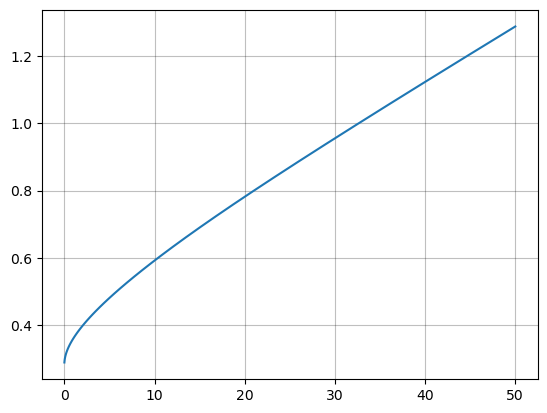

In [44]:
plt.plot(b_grid, c[1,:,1].T)
# plt.xlim(-0.01, 5)
# plt.ylim(None, 0.65)
plt.show()

In [27]:
print(a[1,:,1])
print(z_grid)

[0.03422499 0.03559731 0.03632088 0.03683626 0.03725057 0.03760816
 0.03793441 0.03824285 0.0385395  0.03882854 0.03911314 0.03939589
 0.03967899 0.03996438 0.04025387 0.04054918 0.04085203 0.04116418
 0.04148749 0.04182394 0.04217572 0.04254528 0.04293539 0.04334928
 0.04379072 0.04426419 0.04477508 0.04532997 0.04593697 0.04660616
 0.04735016 0.04818483 0.04913005 0.05021041 0.0514556  0.05289981
 0.05457959 0.05652935 0.05877499 0.06132736 0.06417851 0.06730313
 0.07066482 0.07422436 0.0779465  0.08181915 0.08587563 0.09011236
 0.09452277 0.09910603]
[0.07784149 0.28593115 1.05029622]


## Mapping from $\hat{b} \rightarrow b$

In [7]:
def make_grids(bmax, amax, kmax, nB, nA, nK, nZ, rho_z, sigma_z):
    b_grid = grids.agrid(amax=bmax, n=nB)
    a_grid = grids.agrid(amax=amax, n=nA)
    k_grid = grids.agrid(amax=kmax, n=nK)[::-1].copy()
    e_grid, _, Pi = grids.markov_rouwenhorst(rho=rho_z, sigma=sigma_z, N=nZ)
    return b_grid, a_grid, k_grid, e_grid, Pi

def income(e_grid, tax, w, N):
    z_grid = (1 - tax) * w * N * e_grid
    return z_grid

def make_b_grid(bmax, nA, nB, gamma, a_grid, bhat_grid):
    b_grid = np.zeros([nA, nB])
    for j_a in range(nA):
        # grid for b, starting from the borrowing constraint
        b_grid[j_a,:] = grids.agrid(amax=bmax, n=nB, amin = -gamma*a_grid[j_a])

    # grid for b using the definition of bhat: b = bhat - gamma*a
    b_endo_2d_grid = bhat_grid[None,:] - gamma*a_grid[:,None]

    return b_grid, b_endo_2d_grid

hh_pe = hh_housing.hh_sandbox

In [8]:
def policy_ss(a_grid, b_grid, bhat_grid, b_endo_2d_grid, z_grid, e_grid, k_grid, beta, eis, rb, ra, chi0, chi1, chi2, gamma, tol=1E-12, max_iter=10_000, debug = False):
    '''
    Iterates on the policy functions to find the steady state policy functions
    '''
    # initialize value function and policy function
    Va_p, Vb_p = hh_housing.hh_init(bhat_grid, a_grid, z_grid, eis)
    
    Psi1 = hh_housing.marginal_cost_grid(a_grid, ra, chi0, chi1, chi2)
    # iterate until maximum distance between two iterations falls below tol, fail-safe max of 10,000 iterations
    for it in range(max_iter):
        Va_p, Vb_p, a, b, c, _ = hh_pe(Va_p, Vb_p, a_grid, b_grid, bhat_grid, b_endo_2d_grid, z_grid, e_grid, k_grid, beta, eis, rb, ra, chi0, chi1, chi2, gamma, Psi1, debug) # one iteration of backward induction

        if debug:
            print(f"Iteration #{it}")
            if it % 1000 == 0 and it > 0:
                print("Iteration:", it)
                print("Max difference in a:", np.max(np.abs(a - a_old)))
                print("Max difference in b:", np.max(np.abs(b - b_old)))

        # after iteration 0, can compare new policy function to old one
        if it > 0:
            a_max_diff = np.max(np.abs(a - a_old))
            b_max_diff = np.max(np.abs(b - b_old))
            
            if a_max_diff < tol and b_max_diff < tol:
                print(f"Converged after {it} iterations")
                return Va_p, Vb_p, a, b, c, Psi1
        
        a_old = a.copy()
        b_old = b.copy()

    print(f"Failed to converge after {max_iter} iterations")
    return Va_p, Vb_p, a, b, c, Psi1

def bhat_to_b(gamma, bmax, a_grid, c_bhat, a_bhat, bhat_grid, z_grid, ra, rb, chi0, chi1, chi2, Va_bhat, Vb_bhat):
    '''
    Function to transform the a' and c policy functions from a'(z,bhat,a) and c(z,bhat,a) to a'(z,b,a) and c(z,b,a)
    '''

    nZ, nB, nA = c_bhat.shape
    
    b_grid = np.zeros([nA,nB])
    for j_a in range(nA):
        # grid for b, starting from the borrowing constraint
        b_grid[j_a,:] = grids.agrid(amax=bmax, n=nB, amin = -gamma*a_grid[j_a])
    
    b_endo = bhat_grid[None,:] - gamma*a_grid[:,None]
    c = np.zeros_like(c_bhat)
    a = np.zeros_like(a_bhat)
    b = np.zeros_like(c_bhat)
    Va = np.zeros_like(Va_bhat)
    Vb = np.zeros_like(Vb_bhat)

    for j_z in range(nZ):
        for j_a in range(nA):
            # Create the interpolation function for consumption 
            interp_func_c = interp1d(b_endo[j_a, :], c_bhat[j_z, :, j_a], kind='linear', fill_value="extrapolate")
            interp_func_a = interp1d(b_endo[j_a, :], a_bhat[j_z, :, j_a], kind='linear', fill_value="extrapolate")
            interp_func_Va = interp1d(b_endo[j_a, :], Va_bhat[j_z, :, j_a], kind='linear', fill_value="extrapolate")
            interp_func_Vb = interp1d(b_endo[j_a, :], Vb_bhat[j_z, :, j_a], kind='linear', fill_value="extrapolate")
            # Use the interpolation function to get the interpolated values for the entire b_grid[j_a, :]
            c[j_z, :, j_a] = interp_func_c(b_grid[j_a, :])
            a[j_z, :, j_a] = interp_func_a(b_grid[j_a, :])
            Va[j_z, :, j_a] = interp_func_Va(b_grid[j_a, :])
            Vb[j_z, :, j_a] = interp_func_Vb(b_grid[j_a, :])

    for j_z in range(nZ):
        for j_a in range(nA):
            for j_b in range(nB):
                # Use the original budget constraint to back out b'(z,b,a)
                b[j_z, j_b, j_a] = (z_grid[j_z] + (1 + ra) * a_grid[j_a] + (1 + rb) * b_grid[j_a, j_b]
                                - a[j_z, j_b, j_a] - c[j_z, j_b, j_a]
                                - hh_housing.get_Psi_and_deriv(a[j_z, j_b, j_a], a_grid[j_a], ra, chi0, chi1, chi2)[0])
            
    return b_grid, c, a, b, Va, Vb

In [9]:
# computational parameters
amax = 4000
bmax = 50
kmax = 1
nB = 50
nA = 70
nK = 50
nZ = 3

# model parameters
rho_z = 0.966
sigma_z = 0.92
tax = 0.3560606060606061
w = 0.66
N = 1.0
beta = 0.9762739008880041
eis = 0.5
rb = 0.007500000000000001
ra = 0.012499999999999956
chi0 = 0.25
chi1 = 6.416419594214063
chi2 = 2
gamma = 0.8

bhat_grid, a_grid, k_grid, e_grid, Pi = make_grids(bmax, amax, kmax, nB, nA, nK, nZ, rho_z, sigma_z)
z_grid = income(e_grid, tax, w, N)
b_grid, b_endo_2d_grid = make_b_grid(bmax, nA, nB, gamma, a_grid, bhat_grid)

hh_pe = hh_housing.hh_sandbox

# get the policy functions for a', bhat' and c as a function of z, bhat and a
Va_bhat, Vb_bhat, a_bhat_hgam, b_bhat_hgam, c_bhat_hgam, Psi1 = policy_ss(a_grid, b_grid, bhat_grid, b_endo_2d_grid,z_grid, e_grid, k_grid, beta, eis, rb, ra, chi0, chi1, chi2, gamma, max_iter=5_000, debug = False)

# mapping from bhat to b
b_grid, c, a, b, Va, Vb = bhat_to_b(gamma, bmax, a_grid, c_bhat_hgam, a_bhat_hgam, bhat_grid, z_grid, ra, rb, chi0, chi1, chi2,Va_bhat, Vb_bhat)

c:\Users\thoma\OneDrive\Skrivebord\KU\9. semester\Thesis\Code\Model\HANK\sequence-jacobian\notebooks\hh_housing.py:135: RuntimeWarning: invalid value encountered in power


KeyboardInterrupt: 

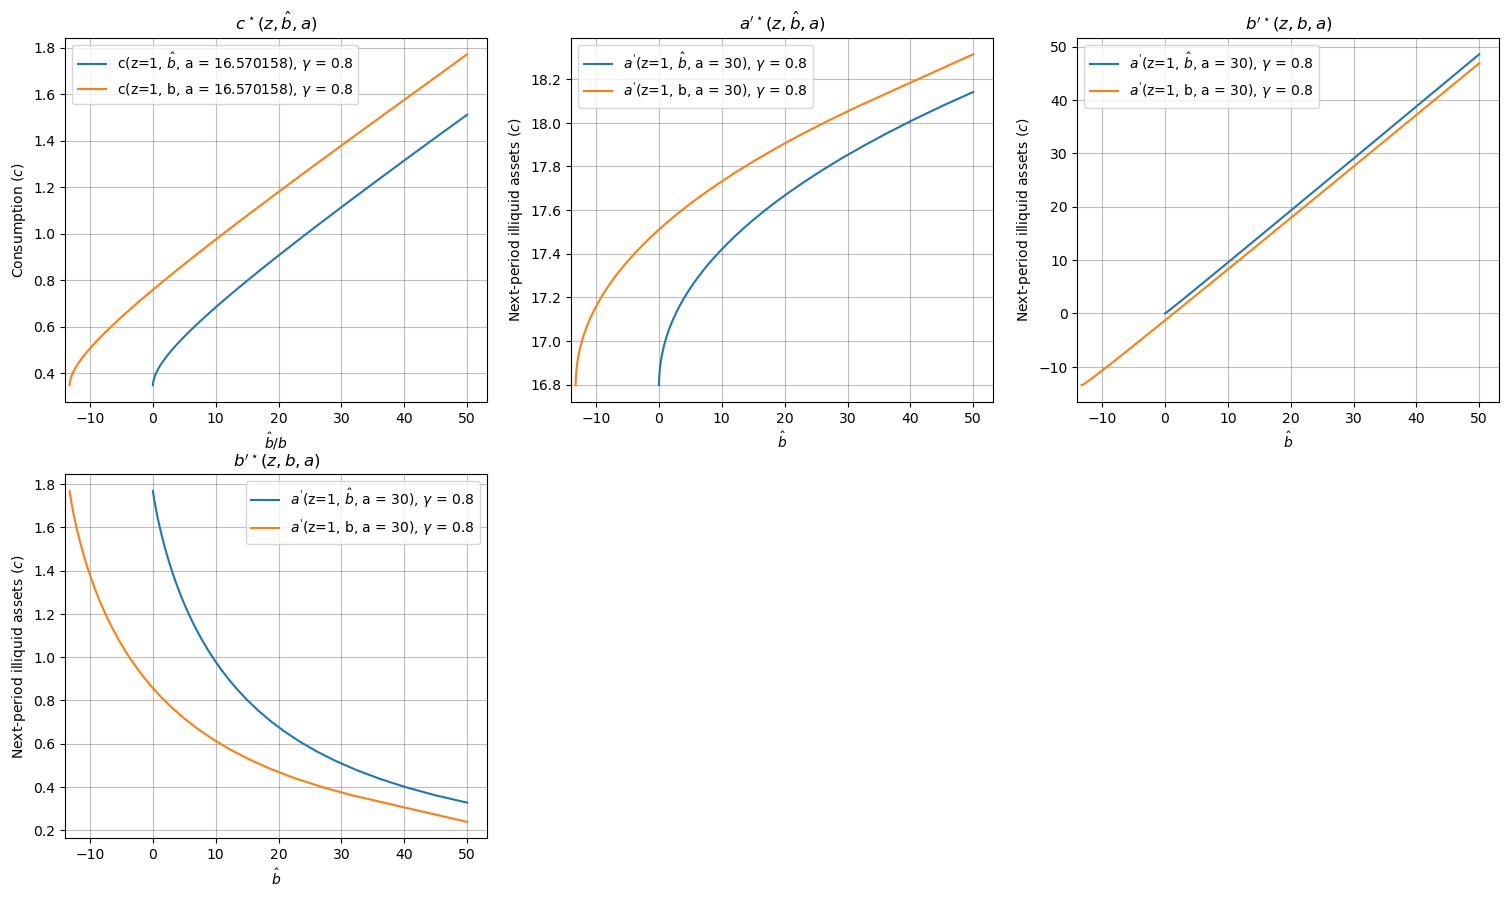

In [5]:
a_point = 30 # the index of the asset level grid point
z_point = 1 # the index of the z grid point

fig = plt.figure(figsize=(18.5, 1.3*8))
ax = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)

# Plotting the consumption function
ax.plot(bhat_grid, c_bhat_hgam[z_point,:,a_point].T, label = fr"c(z={z_point}, $\hat b$, a = {a_grid[a_point]:1f}), $\gamma$ = {gamma}") # c_bhat[nZ,nBhat,nA]
ax.plot(b_grid[a_point,:], c[z_point,:,a_point], label = fr"c(z={z_point}, b, a = {a_grid[a_point]:1f}), $\gamma$ = {gamma}") # c_bhat[nZ,nBhat,nA]
ax.set_xlabel('$\hat{b}/b$')
ax.set_ylabel('Consumption ($c$)')
ax.set_title(r"$c^\star(z,\hat{b}, a)$")
ax.set_xlim(1.05*b_grid[a_point,0], None)
ax.legend()

# Plotting the illiquid asset function
ax2.plot(bhat_grid, a_bhat_hgam[z_point,:,a_point].T, label = fr"$a^'$(z={z_point}, $\hat b$, a = {a_point}), $\gamma$ = {gamma}") # c_bhat[nZ,nBhat,nA]
ax2.plot(b_grid[a_point,:], a[z_point,:,a_point], label = fr"$a^'$(z={z_point}, b, a = {a_point}), $\gamma$ = {gamma}") # c_bhat[nZ,nBhat,nA]
ax2.set_xlabel('$\hat{b}$')
ax2.set_ylabel('Next-period illiquid assets ($c$)')
ax2.set_title(r"$a^{\prime\star}(z,\hat{b}, a)$")
ax2.set_xlim(1.05*b_grid[a_point,0], None)
ax2.legend()

# Plotting the illiquid asset function
ax3.plot(bhat_grid, b_bhat_hgam[z_point,:,a_point].T, label = fr"$a^'$(z={z_point}, $\hat b$, a = {a_point}), $\gamma$ = {gamma}") # c_bhat[nZ,nBhat,nA]
ax3.plot(b_grid[a_point,:], b[z_point,:,a_point], label = fr"$a^'$(z={z_point}, b, a = {a_point}), $\gamma$ = {gamma}") # c_bhat[nZ,nBhat,nA]
ax3.set_xlabel('$\hat{b}$')
ax3.set_ylabel('Next-period illiquid assets ($c$)')
ax3.set_title(r"$b^{\prime\star}(z,b, a)$")
ax3.set_xlim(1.05*b_grid[a_point,0], None)
ax3.legend()

# Plotting the illiquid asset function
ax4.plot(bhat_grid, Va_bhat[z_point,:,a_point].T, label = fr"$a^'$(z={z_point}, $\hat b$, a = {a_point}), $\gamma$ = {gamma}") # c_bhat[nZ,nBhat,nA]
ax4.plot(b_grid[a_point,:], Va[z_point,:,a_point], label = fr"$a^'$(z={z_point}, b, a = {a_point}), $\gamma$ = {gamma}") # c_bhat[nZ,nBhat,nA]
ax4.set_xlabel('$\hat{b}$')
ax4.set_ylabel('Next-period illiquid assets ($c$)')
ax4.set_title(r"$b^{\prime\star}(z,b, a)$")
ax4.set_xlim(1.05*b_grid[a_point,0], None)
ax4.legend()

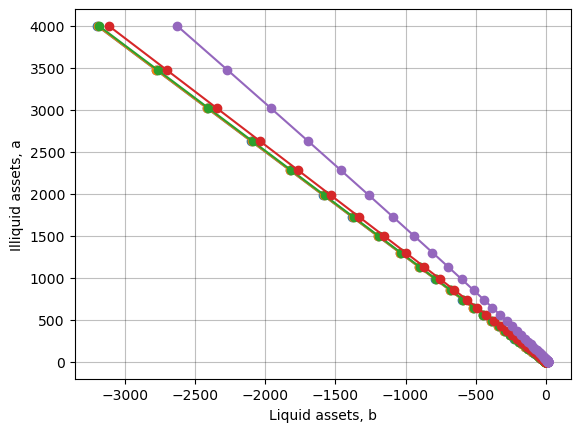

In [188]:
# # create endogenous grid for liquid assets
# b_grid = np.zeros([nA,nB])

# for j_a in range(nA):
#     b_grid[j_a,:] = np.linspace(-gamma_diff*a_grid[j_a], bmax+10, nB)

for j_b in range(nB):
    if j_b % 10 == 0:
        plt.plot(b_grid[:,j_b], a_grid, marker = 'o')
    # plt.scatter(b_grid[:,j_b], a_grid)
plt.xlabel('Liquid assets, b')
plt.ylabel('Illiquid assets, a')
plt.show()

### Legacy

In [137]:
# create endogenous grid for liquid assets
b_grid = np.zeros([nA,nB])

for j_a in range(nA):
    b_grid[j_a,:] = np.linspace(-gamma_diff*a_grid[j_a], bmax+10, nB)
    
b_endo = bhat_grid[None,:] - gamma_diff*a_grid[:,None]
c = np.zeros_like(c_bhat)
print(b_endo.shape)
for j_z in range(nZ):
    for j_a in range(nA):
        for j_b in range(nB):
            c[j_z,j_b,j_a] = np.interp(b_grid[j_a,j_b],b_endo[j_a,:],c_bhat_hgam[j_z,:,j_a])

(70, 150)


In [138]:
b = b_bhat - gamma*a_bhat
b_hgam = b_bhat_hgam - gamma_diff*a_bhat_hgam

# print(a_bhat_hgam)
print(np.sum(b_hgam - b_bhat_hgam))

-11133640.51877072


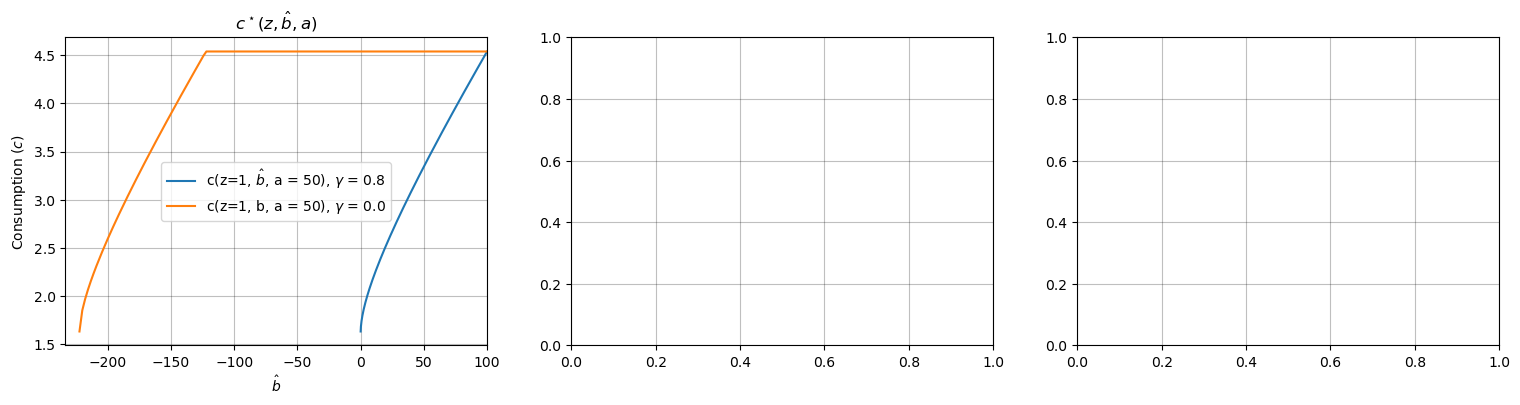

In [139]:
a_point = 50 # the index of the asset level grid point
z_point = 1 # the index of the z grid point

fig = plt.figure(figsize=(18.5, 4))
ax = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

# ax.plot(bhat_grid, c_bhat[z_point,:,a_point].T, label = fr"c(z={z_point}, $\hat b$, a = {a_point}), $\gamma$ = {gamma}") # c_bhat[nZ,nBhat,nA]
ax.plot(bhat_grid, c_bhat_hgam[z_point,:,a_point].T, label = fr"c(z={z_point}, $\hat b$, a = {a_point}), $\gamma$ = {gamma + gamma_diff}") # c_bhat[nZ,nBhat,nA]
ax.plot(b_grid[a_point,:], c[z_point,:,a_point], label = fr"c(z={z_point}, b, a = {a_point}), $\gamma$ = {gamma}") # c_bhat[nZ,nBhat,nA]
ax.set_xlabel('$\hat{b}$')
ax.set_ylabel('Consumption ($c$)')
ax.set_title(r"$c^\star(z,\hat{b}, a)$")
ax.set_xlim(1.05*b_grid[a_point,0], 100)
ax.legend()

# ax2.plot(bhat_grid, b_bhat[z_point,:,a_point].T) # c_bhat[nZ,nBhat,nA]
# ax2.plot(bhat_grid, b_bhat_hgam[z_point,:,a_point].T) # c_bhat[nZ,nBhat,nA]
# ax2.set_xlabel('$\hat{b}$')
# ax2.set_ylabel('Next period ($b\prime $)')
# ax2.set_title(r"$\hat{b}^{\prime\star}(z,\hat{b}, a)$")

# # ax3.plot(bhat_grid, b[z_point,:,a_point].T) # c_bhat[nZ,nBhat,nA]
# # ax3.plot(bhat_grid, b_bhat_hgam[z_point,:,a_point].T) # c_bhat[nZ,nBhat,nA]
# ax3.plot(bhat_grid, b_hgam[z_point,:,a_point].T) # c_bhat[nZ,nBhat,nA]
# # ax3.plot(bhat_grid, b_bhat_hgam[z_point,:,a_point].T - b_hgam[z_point,:,a_point].T) # c_bhat[nZ,nBhat,nA]
# ax3.set_xlabel('$\hat{b}$')
# ax3.set_ylabel('Next period ($b^\prime $)')
# ax3.set_title(r"$b^{\prime\star}(z,\hat{b}, a)$")

plt.show()

### Mapping from $\hat{b} \rightarrow b$

In [3]:
# computational parameters
bhat_max = 50
hmax = 5
nB = 50
nH = 100

# model parameters
q_lag = 1
gamma = 0.5

# creating grids 
bhat_grid = np.linspace(0, bhat_max, nB)
h_grid = np.linspace(0, hmax, nH)


b_endo = bhat_grid[None,:] - gamma*q_lag* h_grid[:,None] # endogenous grid, size nH x nB 

do_print = False
do_plot = False
if do_print:
    print(b_endo.shape)
    print(b_endo[:,0:1])

if do_plot:
    plt.plot(b_endo[:,0:1], h_grid)
    plt.plot(b_endo[:,40:41], h_grid)
    plt.xlabel('Borrowing ($b$)')
    plt.ylabel('Housing ($h$)')
    plt.show()

In [60]:
# computational parameters
amax = 4000
bmax = 500
kmax = 1
nB = 50
nA = 70
nK = 50
nZ = 3

# model parameters
rho_z = 0.966
sigma_z = 0.92
tax = 0.3560606060606061
w = 0.66
N = 1.0
beta = 0.9762739008880041
eis = 0.5
rb = 0.007500000000000001
ra = 0.012499999999999956
chi0 = 0.25
chi1 = 6.416419594214063
chi2 = 2

gamma = 0.5

def make_grids(bmax, amax, kmax, nB, nA, nK, nZ, rho_z, sigma_z):
    b_grid = grids.agrid(amax=bmax, n=nB)
    a_grid = grids.agrid(amax=amax, n=nA)
    k_grid = grids.agrid(amax=kmax, n=nK)[::-1].copy()
    e_grid, _, Pi = grids.markov_rouwenhorst(rho=rho_z, sigma=sigma_z, N=nZ)
    return b_grid, a_grid, k_grid, e_grid, Pi

def income(e_grid, tax, w, N):
    z_grid = (1 - tax) * w * N * e_grid
    return z_grid

bhat_grid, a_grid, k_grid, e_grid, Pi = make_grids(bmax, amax, kmax, nB, nA, nK, nZ, rho_z, sigma_z)
# print(bhat_grid)
z_grid = income(e_grid, tax, w, N)
b_grid = np.linspace(-10, bmax-10, nB)
b_endo = bhat_grid[None,:] - gamma*q_lag*a_grid[:,None]

hh_pe = hh_housing.hh_sandbox
Va, Vb, a, b, c_bhat, Psi1 = policy_ss(a_grid, bhat_grid, z_grid, e_grid, k_grid, beta, eis, rb, ra, chi0, chi1, chi2, gamma, max_iter=10_000, debug = False)

Converged after 1256 iterations


In [61]:
c = np.zeros_like(c_bhat)
for j_z in range(nZ):
    for j_a in range(nA):
        for j_b in range(nB):
            # c[j_z,j_b,j_a] = np.interp(b_grid[j_b],b_endo[j_a,:],c_bhat[j_z,:,j_a])
            c[j_z,j_b,j_a] = np.interp(b_endo[j_a,j_b],bhat_grid[:],c_bhat[j_z,:,j_a])